In [1]:
#accessing netcdf files from Hector's folders
import os, glob, sys
sys.path.append("//nobackup//amondal//Python//Hector_Python_Scripts")
sys.path.append("//nobackup/amondal//Python//mit_geos_analysis")
#from mds_store import openmdsdataset
#playing with netcdf - xarray
import numpy as np
import xarray as xr
import dask.array as da
import matplotlib.pyplot as plt
# How about visualization?
%matplotlib inline
import netCDF4
from netCDF4 import Dataset
#from xmitgcm import open_mdsdataset
from GetNCDataSet import getMITNCDataSet
from MITllc2160Depth import *
sys.path.append("//nobackup/amondal//Python//xmitgcm//xmitgcm")
from xmitgcm.mds_store import open_mdsdataset
import xrft


from dask.distributed import Client
client = Client(memory_limit='90GB',n_workers = 40, threads_per_worker=1)

/home6/amondal/.conda/envs/xmitgcm3/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39477 instead
  warnings.warn(


In [2]:
import xgcm

In [2]:
from spectral_analysis_code import *

In [4]:
#depthToZlayer(25)
zlayerToDepth(25)

154.99

Let me look at hbl for my region:

In [3]:
kpphbl = getMITNCDataSet('/nobackup/amondal/NCData/20211228_HBL_GulfStream_FULLYEAR/', 'KPPhbl', 0,0 )

Time combined dataset has been opened.
I concatenated the first Z-layer


In [4]:
hbl = kpphbl.KPPhbl.compute()

In [5]:
def coarseGrainHbl_MAX(hblset):
    periodlength = 24
    periodnum = int(hblset.dims['time'] / periodlength)
    hblsel = hblset['KPPhbl']
    perioddepths = np.empty(periodnum)
    hblcoarsegrain = np.empty(0)
    for index in range(0,periodnum):
        perioddepths[index] = hblsel[index*periodlength:(index+1)*periodlength].max(dim='time').values
        hblcoarsegrain = np.concatenate((hblcoarsegrain, np.full(periodlength, perioddepths[index])),casting='same_kind')
    hMax = xr.DataArray(data = hblcoarsegrain, dims = hblsel.dims, coords = hblsel.coords)
    return hMax

def coarseGrainHblArray_MAX(hblarray, cgperiod):
    periodlength = cgperiod #hours over which you want to coarse grain
    periodnum = int(hblarray['time'].size / periodlength)
    hblsel = hblarray
    perioddepths = np.empty(periodnum)
    hblcoarsegrain = np.empty(0)
    for index in range(0,periodnum):
        perioddepths[index] = hblsel[index*periodlength:(index+1)*periodlength].max(dim='time').values
        hblcoarsegrain = np.concatenate((hblcoarsegrain, np.full(periodlength, perioddepths[index])),casting='same_kind')
    hMax = xr.DataArray(data = hblcoarsegrain, dims = hblsel.dims, coords = hblsel.coords)
    return hMax

Text(0.5, 1.0, 'Max Gulf Stream HBL (Coarse Grained by Max over 3 days)')

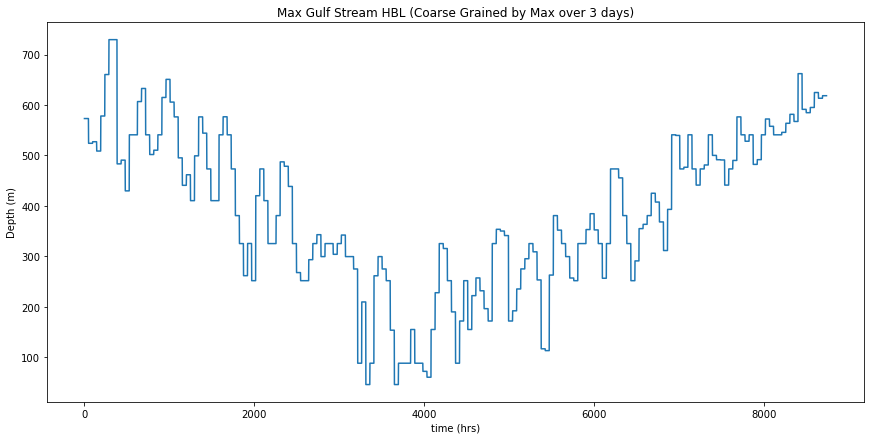

In [6]:
hblm = hbl.max(["lat","lon"])
hblm_cg = coarseGrainHblArray_MAX(hblm, 48)
%matplotlib inline
hblm_cg.plot(aspect=2, size=6)
plt.tight_layout()
plt.xlabel('time (hrs)')
plt.ylabel('Depth (m)')
plt.title('Max Gulf Stream HBL (Coarse Grained by Max over 3 days)')

Text(0.5, 1.0, 'Max Gulf Stream HBL (Coarse Grained by Max over 3 days)')

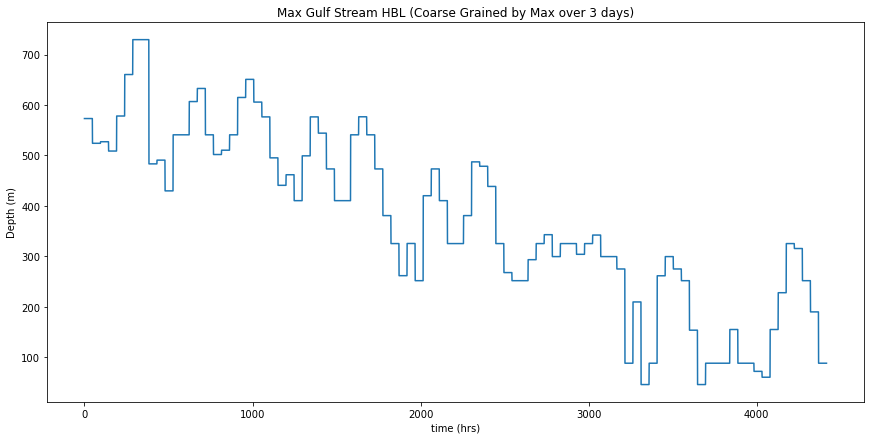

In [7]:
hblm = hbl.max(["lat","lon"])
hblm_cg = coarseGrainHblArray_MAX(hblm, 48)
%matplotlib inline
hblm_cg[0:4416].plot(aspect=2, size=6)
plt.tight_layout()
plt.xlabel('time (hrs)')
plt.ylabel('Depth (m)')
plt.title('Max Gulf Stream HBL (Coarse Grained by Max over 3 days)')

So Patrice suggested making movies of W T in the bigger region in real space/time domain. He also suggested doing a moving window of length 3 days. This is for 6 months of gulf stream data.

In [3]:
T15 = getMITNCDataSet('/nobackup/amondal/NCData/20211116_QTprime_openocean_3month_bigger_region/', 'Theta', 15,15 )
T15c = T15.compute()

Time combined dataset has been opened.
I concatenated the first Z-layer


Cool, so this is the the right folder! So I can do Zlayers 25,30,35, and maybe 40? We could even do 45.

In [7]:
W15 = getMITNCDataSet('/nobackup/amondal/NCData/20211116_QTprime_openocean_3month_bigger_region/', 'W', 15,15)
W15c = W15.compute()

Time combined dataset has been opened.
I concatenated the first Z-layer


In [9]:

Theta15_reg = regularizeCoordinates(T15.Theta,'linear',timeunits = 'hours')
W15_reg = regularizeCoordinates(W15.W, 'linear', timeunits = 'hours')

In [12]:
Theta15_reg_t = xrft.detrend(Theta15_reg, dim = ['time'], detrend_type = 'linear')
W15_reg_t = xrft.detrend(W15_reg, dim = ['time'], detrend_type = 'linear')
Theta15_reg_txy = xrft.detrend(Theta15_reg_t, dim = ['xdim','ydim'], detrend_type = 'linear')
W15_reg_txy = xrft.detrend(W15_reg_t, dim = ['xdim', 'ydim'], detrend_type = 'linear')

In [13]:
WpTp = W15_reg_txy*Theta15_reg_txy

In [15]:
WpTp_1week = WpTp[0:24*7]

In [17]:
WpTp_1week_movingavg = movingWindowAverage(WpTp_1week, 'time', 24)

In [16]:
def movingWindowAverage(xarraydata, dim, windowsize):
    chunks = xarraydata.chunk({"xdim": 100, "ydim": 100})
    xavg = chunks / windowsize
    for index in range(1,windowsize):
        if (dim =='time'):
            xavg += chunks.shift(time=-1*index, fill_value = 0) / windowsize
            # add other potential dimensions. xarray.shift doesn't allow us to pick dimensions in an easier way
        else:
            xavg += xavg
        
    return xavg[0:-1*windowsize]

In [18]:
WpTp_1week_movingavgc = WpTp_1week_movingavg.compute()

In [20]:
WpTp_1month = WpTp[0:24*30]

In [21]:
WpTp_1month_movingavg = movingWindowAverage(WpTp_1month, 'time', 24)

In [22]:
WpTp_1month_movingavgc = WpTp_1month_movingavg.compute()

In [23]:
WpTp_1month_movingavgc

<xarray.DataArray (time: 696, xdim: 500, ydim: 500)>
array([[[ 2.84181469e-05,  1.13799231e-05, -2.47066745e-05, ...,
         -1.01601289e-05, -1.37507307e-05, -1.07677123e-05],
        [ 1.39654190e-06, -4.79153148e-05,  1.27752516e-05, ...,
         -2.54057968e-05, -4.09135578e-05, -8.75166161e-06],
        [-1.83265696e-05, -2.30708795e-06,  3.99065585e-05, ...,
         -5.80186553e-05, -1.33998539e-05,  3.74791312e-05],
        ...,
        [ 7.70691455e-06, -4.45365975e-05,  4.59590305e-06, ...,
         -1.05043631e-04, -4.38274739e-04, -6.78628302e-04],
        [ 3.05732299e-05, -1.53358158e-05,  4.45074599e-05, ...,
         -1.58235912e-04, -2.39228576e-04, -4.42993103e-04],
        [ 1.94208307e-04,  4.43701827e-05,  1.68789008e-05, ...,
         -3.11115089e-05, -2.90606928e-04, -4.38101252e-04]],

       [[ 1.73336196e-05,  7.24690099e-06, -2.16410037e-05, ...,
         -1.55518064e-05, -1.76255752e-05, -1.01748796e-05],
        [ 4.50281987e-06, -4.84769086e-05,  4.74422141e-06, ...,
         -2.97363556e-05, -4.38199665e-05, -1.28462553e-05],
        [-1.85048814e-05, -1.40555220e-05,  3.50929522e-05, ...,
         -5.79825628e-05, -1.82302462e-05,  3.90515064e-05],
...
        [-7.45870355e-05,  4.84420141e-06,  1.31989035e-04, ...,
          4.25870831e-08, -5.23559689e-06,  9.32822993e-07],
        [-1.87058926e-06,  8.12460658e-05,  1.10152020e-04, ...,
         -1.45016533e-05,  1.70628418e-06, -1.85979719e-06],
        [ 3.32720121e-05, -2.20913208e-06,  1.07130299e-05, ...,
          1.41039840e-06,  1.98999136e-06, -1.15196600e-06]],

       [[-6.35970084e-06, -3.30139269e-05, -3.76709145e-05, ...,
         -5.50498715e-06, -1.69444518e-06, -2.72120362e-06],
        [ 2.47431296e-05,  2.58468665e-05, -4.99172233e-05, ...,
         -4.17958990e-06,  3.22541938e-06, -4.94235062e-06],
        [ 6.79068101e-06,  5.25742947e-05, -1.58953883e-05, ...,
         -4.46053516e-06,  5.40895062e-07, -1.85491133e-06],
        ...,
        [-6.39983019e-05,  1.69335935e-05,  1.24274951e-04, ...,
         -1.59860342e-06, -5.21256498e-06,  8.41649015e-07],
        [ 2.69225398e-05,  8.46189995e-05,  8.62248705e-05, ...,
         -1.47175312e-05,  1.03084260e-06, -1.36718347e-06],
        [ 5.40663577e-05, -9.21080270e-06, -5.14740503e-06, ...,
          1.77727060e-06,  1.43066104e-06,  9.03069935e-08]]])
Coordinates:
  * time     (time) float64 0.0 1.0 2.0 3.0 4.0 ... 692.0 693.0 694.0 695.0
  * xdim     (xdim) float64 0.0 1.738 3.476 5.214 ... 862.0 863.8 865.5 867.2
  * ydim     (ydim) float64 0.0 4.448 8.896 ... 2.211e+03 2.215e+03 2.22e+03

In [ ]:
# something like this for making the movieb
from xmovie import Movie
Qvert_winavg_3days_cg = Qvert_winavg_3days[0:-1:12, 0:-1:2, 0:-1:2]#.plot(size=6, aspect=1.4)
mov = Movie(Qvert_winavg_3days_cg.chunk({'time':100}))
mov.save('/nobackup/amondal/NCData/Qmovies/Q25_3daywinavg.mp4', parallel=True)

I'm moving this all to a local python script because jupyter seems to have a hard time with it - the moving window average is quite expensive.

1/21 - Well neither jupyter nor the compute node seem to be able to make a movie. So I'm trying to use as little of Jupyter's memory on that. Vertical Q's have been loaded from Dimitris' repo

In [3]:
Qv25 = getMITNCDataSet('/nobackup/amondal/NCData/20211116_QTprime_openocean_3month_bigger_region/', 'Qv', 25,25 )

Time combined dataset has been opened.
I concatenated the first Z-layer


In [4]:
Qv25_reg = regularizeCoordinates(Qv25.Qv,'linear',timeunits = 'hours')

In [5]:
Qv25_reg

<xarray.DataArray (time: 2208, xdim: 450, ydim: 700)>
array([[[ 8.45966797e+04,  8.45966797e+04,  6.63983125e+04, ...,
          5.50756992e+04,  8.43889766e+04,  7.79261562e+04],
        [ 8.48825078e+04,  7.76448203e+04,  5.42846562e+04, ...,
          8.30710547e+04,  6.82278828e+04,  4.56920234e+04],
        [ 4.12072969e+04,  4.12072969e+04,  1.62663916e+04, ...,
          2.42130957e+04, -5.40785703e+04, -1.31128906e+05],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          6.21354609e+04,  2.04669844e+04, -3.13756445e+04],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          5.02026562e+04,  2.83412773e+04, -1.11339043e+04],
        [ 1.32497979e+04,  5.72392432e+03,  2.51483252e+03, ...,
          2.05041973e+04,  3.74602383e+04,  6.54314893e+03]],

       [[ 3.80021016e+04,  3.80021016e+04,  2.05413184e+04, ...,
          3.56972578e+04,  2.02082129e+04,  4.18375039e+04],
        [ 3.07587461e+04,  1.28626631e+04, -2.62197729e+03, ...,
          7.72589453e+04,  5.68876406e+04,  2.51698477e+04],
        [-1.63777764e+04, -1.63777764e+04, -1.77593613e+04, ...,
          3.53217344e+04,  1.38094092e+04, -4.63588672e+04],
...
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -6.43199180e+04, -7.58638672e+04, -6.78095938e+04],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -6.14307617e+04, -7.43521641e+04, -7.85147031e+04],
        [ 7.12844336e+03, -6.43910596e+03, -4.12040869e+03, ...,
         -4.37508398e+04, -5.38447969e+04, -7.33763828e+04]],

       [[ 6.81646484e+04,  6.81646484e+04,  6.64578438e+04, ...,
         -6.66159141e+04, -3.16595313e+04, -1.14579305e+05],
        [ 6.21621445e+04,  9.21472422e+04,  8.28849062e+04, ...,
         -7.51432422e+04, -6.38041758e+04, -1.47174422e+05],
        [ 9.20131875e+04,  9.20131875e+04,  6.83312422e+04, ...,
         -1.01577451e+04, -8.87747266e+03, -4.04922969e+04],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -4.32945508e+04, -7.99909687e+04, -7.68687266e+04],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -9.14290723e+03, -5.81756641e+04, -8.19297812e+04],
        [ 2.80540918e+04,  5.52080322e+03,  2.97760010e+02, ...,
          2.17792656e+04, -2.18169492e+04, -5.83831797e+04]]])
Coordinates:
  * time     (time) float64 0.0 1.0 2.0 3.0 ... 2.205e+03 2.206e+03 2.207e+03
  * xdim     (xdim) float64 0.0 1.666 3.332 4.999 ... 743.1 744.8 746.5 748.1
  * ydim     (ydim) float64 0.0 4.448 8.896 ... 3.1e+03 3.105e+03 3.109e+03

In [10]:
Qvert_winavg_3days = movingWindowAverage(Qv25_reg, 'time', 72)

In [11]:
Qvert_winavg_3days

<xarray.DataArray (time: 2136, xdim: 450, ydim: 700)>
dask.array<getitem, shape=(2136, 450, 700), dtype=float64, chunksize=(2136, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 1.0 2.0 3.0 ... 2.133e+03 2.134e+03 2.135e+03
  * xdim     (xdim) float64 0.0 1.666 3.332 4.999 ... 743.1 744.8 746.5 748.1
  * ydim     (ydim) float64 0.0 4.448 8.896 ... 3.1e+03 3.105e+03 3.109e+03

In [ ]:
Qvert_winavg_3days.to_netcdf('/nobackup/amondal/NCData/20211116_QTprime_openocean_3month_bigger_region/Qvert25_winavg_3days.nc4')